In [ ]:
import pandas as pd
import json 
import datetime as dt
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1=pd.read_csv('/content/drive/My Drive/data_user_segment.csv')

In [ ]:
df1.head()

,total_discount,total_order,number_of_discount,active_day,active_week,discount_ratio,platform,avg_discount,prod_day,pro_week,total_order_f,n_platform,number_of_discount_f,clusters,name
0,2061000.0,238,219,44,8,0.920168,web,9410.958904,5.409091,29.750,5.472271,2,5.389072,1,cluster 3
1,0.0,8,0,8,4,0.000000,android,0.000000,1.000000,2.000,2.079442,0,-inf,3,cluster 1
2,4000.0,67,1,32,8,0.014925,ios,4000.000000,2.093750,8.375,4.204693,1,0.000000,2,cluster 4
3,16000.0,3,2,3,3,0.666667,ios,8000.000000,1.000000,1.000,1.098612,1,0.693147,0,cluster 2
4,219000.0,51,46,25,8,0.901961,android,4760.869565,2.040000,6.375,3.931826,0,3.828641,1,cluster 3


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5975 entries, 0 to 5974
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_discount        5975 non-null   float64
 1   total_order           5975 non-null   int64  
 2   number_of_discount    5975 non-null   int64  
 3   active_day            5975 non-null   int64  
 4   active_week           5975 non-null   int64  
 5   user_id               5975 non-null   int64  
 6   discount_ratio        5975 non-null   float64
 7   platform              5975 non-null   object 
 8   avg_discount          5975 non-null   float64
 9   prod_day              5975 non-null   float64
 10  pro_week              5975 non-null   float64
 11  total_order_f         5975 non-null   float64
 12  n_platform            5975 non-null   int64  
 13  number_of_discount_f  5975 non-null   float64
 14  clusters              5975 non-null   int64  
 15  name                 

#### 5975 user muốn segment thành từng nhóm để có chính sách riêng cho từng nhóm.

### Clean data & build features

In [ ]:
def toNumeric(dataframe, fromAtt, toAtt):
  if dataframe[fromAtt].dtype == type(object):
      le = preprocessing.LabelEncoder()# Dummies / One Hot Encoder  
      dataframe[toAtt] = le.fit_transform(dataframe[fromAtt].astype(str))   
  return dataframe

In [ ]:
df6=df1[['total_discount','total_order','number_of_discount','active_day','active_week','user_id','discount_ratio']]
df6['avg_discount']=df6['total_discount']/df6['number_of_discount']
df6['prod_day']=df6['total_order']/df6['active_day']
df6['pro_week']=df6['total_order']/df6['active_week']
df6['avg_discount']=df6['avg_discount'].fillna(0)
df6['total_order_f']=np.log(df6.total_order)
df6['number_of_discount_f']=np.log(df6.number_of_discount)
df6['number_of_discount_f']=df6['number_of_discount_f'].fillna(0)
df8=df6[(df6.total_order!=1)]
df8['number_of_discount_f']=np.where(df8['number_of_discount_f']==-np.inf, 0,df8['number_of_discount_f'])
samples=df8[['number_of_discount_f','prod_day','active_day',
      'discount_ratio',
      'total_order_f']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### sử dụng 'log của order' và 'log của discount' thay cho 'order' và 'discount' làm feature cho việc phân nhóm cluster

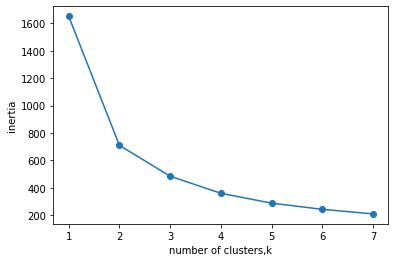

In [ ]:
## scaler
scaler=StandardScaler()
_scaler = scaler.fit_transform(samples)
with open("user_segment_scalers.pkl", "wb") as outfile:
    pkl.dump(scaler, outfile)


ks=range(1,8)
inertias=[]
for i in ks:
    model= KMeans(n_clusters=i)
    model.fit(_scaler)
    inertias.append(model.inertia_)
plt.plot(ks,inertias,'-o')
plt.xlabel('number of clusters,k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### chọn K= 4

In [ ]:
df8.head()

,total_discount,total_order,number_of_discount,active_day,active_week,discount_ratio,avg_discount,prod_day,pro_week,total_order_f,number_of_discount_f,clusters
0,2061000.0,238,219,44,8,0.920168,9410.958904,5.409091,29.750,5.472271,5.389072,1
1,0.0,8,0,8,4,0.000000,0.000000,1.000000,2.000,2.079442,0.000000,3
2,4000.0,67,1,32,8,0.014925,4000.000000,2.093750,8.375,4.204693,0.000000,0
3,16000.0,3,2,3,3,0.666667,8000.000000,1.000000,1.000,1.098612,0.693147,2
4,219000.0,51,46,25,8,0.901961,4760.869565,2.040000,6.375,3.931826,3.828641,1


## Kmeans

In [ ]:
    
## kmeans. k= 4
kmeans=KMeans(n_clusters=4)
features=kmeans.fit(_scaler)
clusters=features.predict(_scaler)

filename = 'sgn_user_segment.sav'
pkl.dump(features, open(filename, 'wb'))

df8['clusters']=clusters


## Visualize cluster in 3-D chart

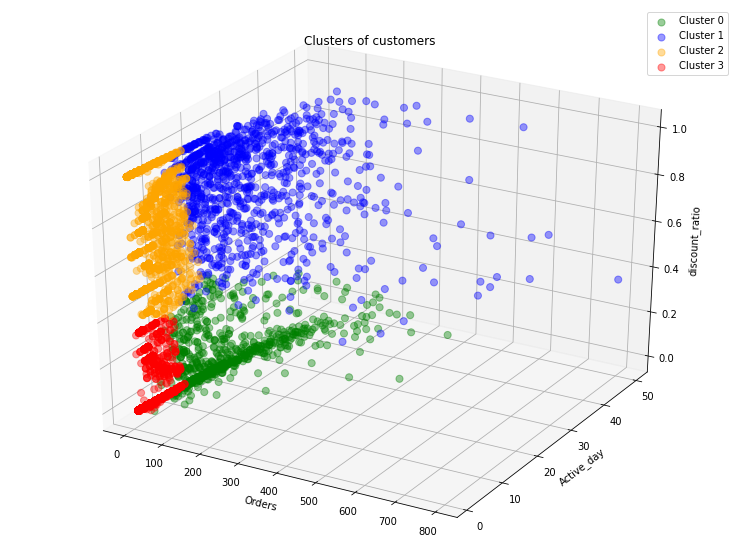

In [ ]:
fig = plt.figure(figsize=(13,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['green','blue', 'orange','red']
for i in range(0,4):
    dx.scatter(df8[df8.clusters == i].total_order, 
               df8[df8.clusters == i].active_day, 
               df8[df8.clusters == i].discount_ratio,
               c = colors[i], 
               label = 'Cluster ' + str(i), 
               s=50,
               alpha=0.4)

dx.set_title('Clusters of customers')
dx.set_xlabel('Orders')
dx.set_ylabel('Active_day')
dx.set_zlabel('discount_ratio')
dx.legend()

## Analysis

In [ ]:
df12=df8.groupby('clusters').agg({'user_id':'count'}).reset_index()

Text(0.5, 1.0, 'number user of cluster')

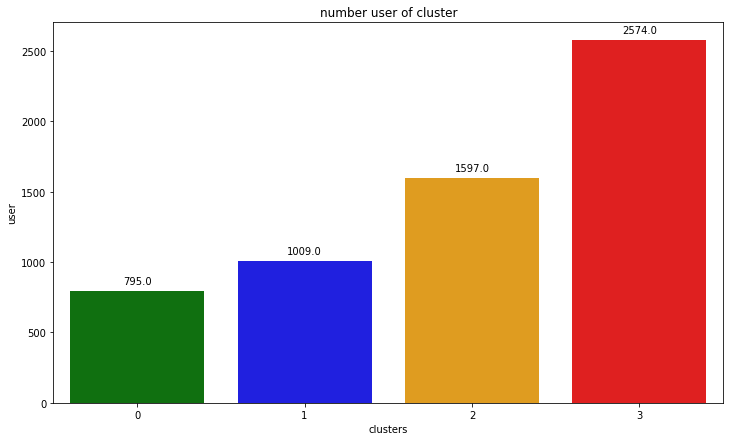

In [ ]:
f, ax =plt.subplots(figsize=(12,7))
sns.barplot(x=df12['clusters'],y=df12['user_id'],palette=['green','blue', 'orange','red'],data=df12)
ax.set_ylabel('user')
for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_title('number user of cluster')

Text(0.5, 1.0, 'active_day vs discount_radio')

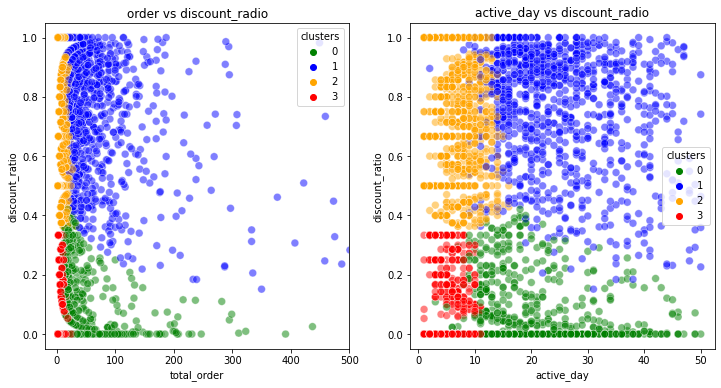

In [ ]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0]
sns.scatterplot(x='total_order', y='discount_ratio', hue='clusters', palette=['green','blue', 'orange','red'],s=60,
               alpha=0.5,data=df8,ax=ax1)
ax1.set_title('order vs discount_radio')
ax1.set_xlim(-20,500)

ax3=ax[1]
sns.scatterplot(x='active_day', y='discount_ratio', hue='clusters',palette=['green','blue', 'orange','red'],s=60,
               alpha=0.5,data=df8,ax=ax3)
ax3.set_title('active_day vs discount_radio')


Text(0.5, 1.0, 'number_of_discount vs discount_radio')

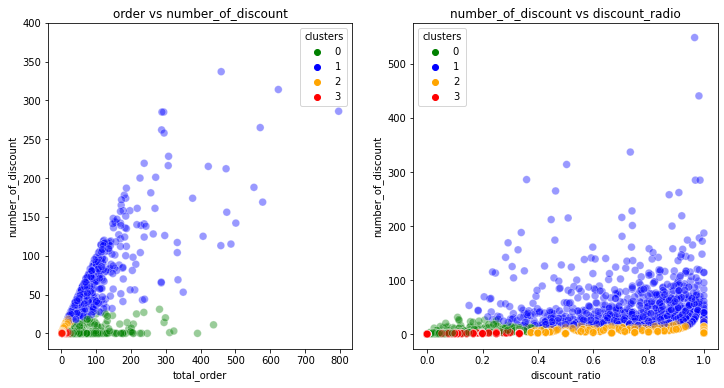

In [ ]:
f, ax=plt.subplots(1,2,figsize=(12,6))
ax1=ax[0]
sns.scatterplot(x='total_order', y='number_of_discount', hue='clusters', palette=['green','blue', 'orange','red'],s=60,
               alpha=0.4,data=df8,ax=ax1)
ax1.set_title('order vs number_of_discount')
ax1.set_ylim(-20,400)

ax3=ax[1]
sns.scatterplot( x='discount_ratio',y='number_of_discount', hue='clusters',palette=['green','blue', 'orange','red'],s=60,
               alpha=0.4,data=df8,ax=ax3)
ax3.set_title('number_of_discount vs discount_radio')

Text(0.5, 1.0, 'discount_ratio')

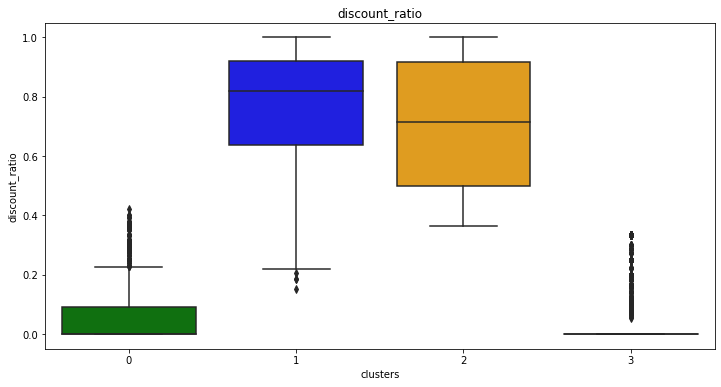

In [ ]:
f, ax=plt.subplots(figsize=(12,6))
sns.boxplot(x="clusters", y="discount_ratio", data=df8,palette=['green','blue', 'orange','red'], ax=ax)
plt.title('discount_ratio')

Text(0.5, 1.0, 'log of total_order')

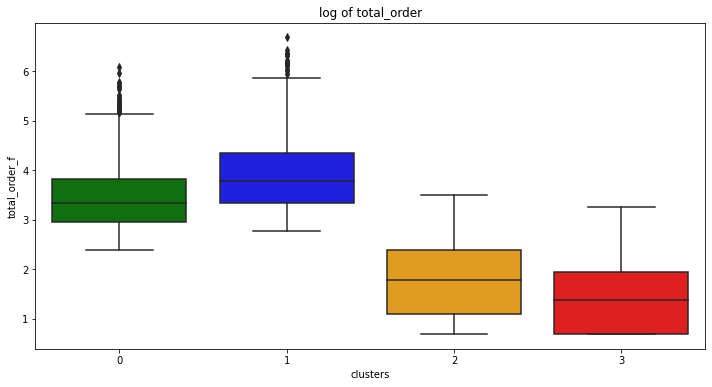

In [ ]:
f, ax=plt.subplots(figsize=(12,6))
sns.boxplot(x="clusters", y="total_order_f", data=df8,palette=['green','blue', 'orange','red'], ax=ax)
plt.title('log of total_order')

Text(0.5, 1.0, 'active_day')

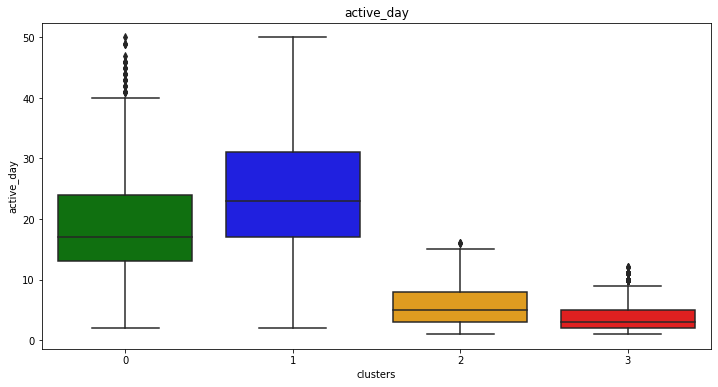

In [ ]:
f, ax=plt.subplots(figsize=(12,6))
sns.boxplot(x="clusters", y="active_day", data=df8,palette=['green','blue', 'orange','red'], ax=ax)
plt.title('active_day')